# ToyBrain dataset tutorial:
# How to generate a ToyBrain dataset with a desired `image <--> covariates` relationship ?

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
from sklearn import datasets, linear_model
from tqdm.notebook import tqdm
import random
import math
import json

from create_toybrains import ToyBrainsData
from utils.vizutils import *

## (Step 1) Create a configuration file
that contains, <br>
(a) the list of covariates and labels <br>
(b) the relationship between each covaraite and the image generation attributes <br><br>
The config can be stored in `configs/` folder as shown below:

In [3]:
! head -30 configs/lbl5cov3_base.py

import numpy as np
import os, shutil 
from copy import copy, deepcopy
        
# List of all covariates
COVARS = {
            'cov_sex' :      dict(states=['Male', 'Female']),
            'cov_site':      dict(states=['siteA', 'siteB', 'siteC', 'siteD']),
            'cov_age' :      dict(states=np.arange(20, 50+1)),
            'lbl_shp1'      : dict(states=[True, False]),
            'lbl_shp1-shp2' : dict(states=[True, False]),
            'lbl_shp1-vol'  : dict(states=[True, False]),
            'lbl_shp2-vent' : dict(states=[True, False]),
            'lbl_shp2-int' : dict(states=[True, False]),
        }

# Rules about which covariate-state influences which generative variables
RULES_COV_TO_GEN = {
    ## `sex -> brain_vol` 
    'cov_sex':{
        'Male':{ # if male increase the changes of sampling a higher brain volume
            'brain-vol_radminor': dict(idxs=(-1,-2),amt=(5,3)), 
            # 'brain-vol_radmajor': dict(idxs=(-1,-2),amt=(5,3))
        },
        'Female':{ 

### Check the configuration

In [47]:
toy = ToyBrainsData(base_config='configs.lbl5cov3_base.py')

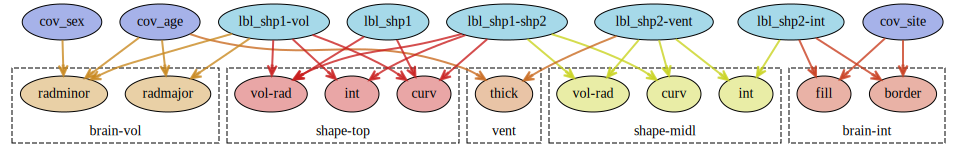

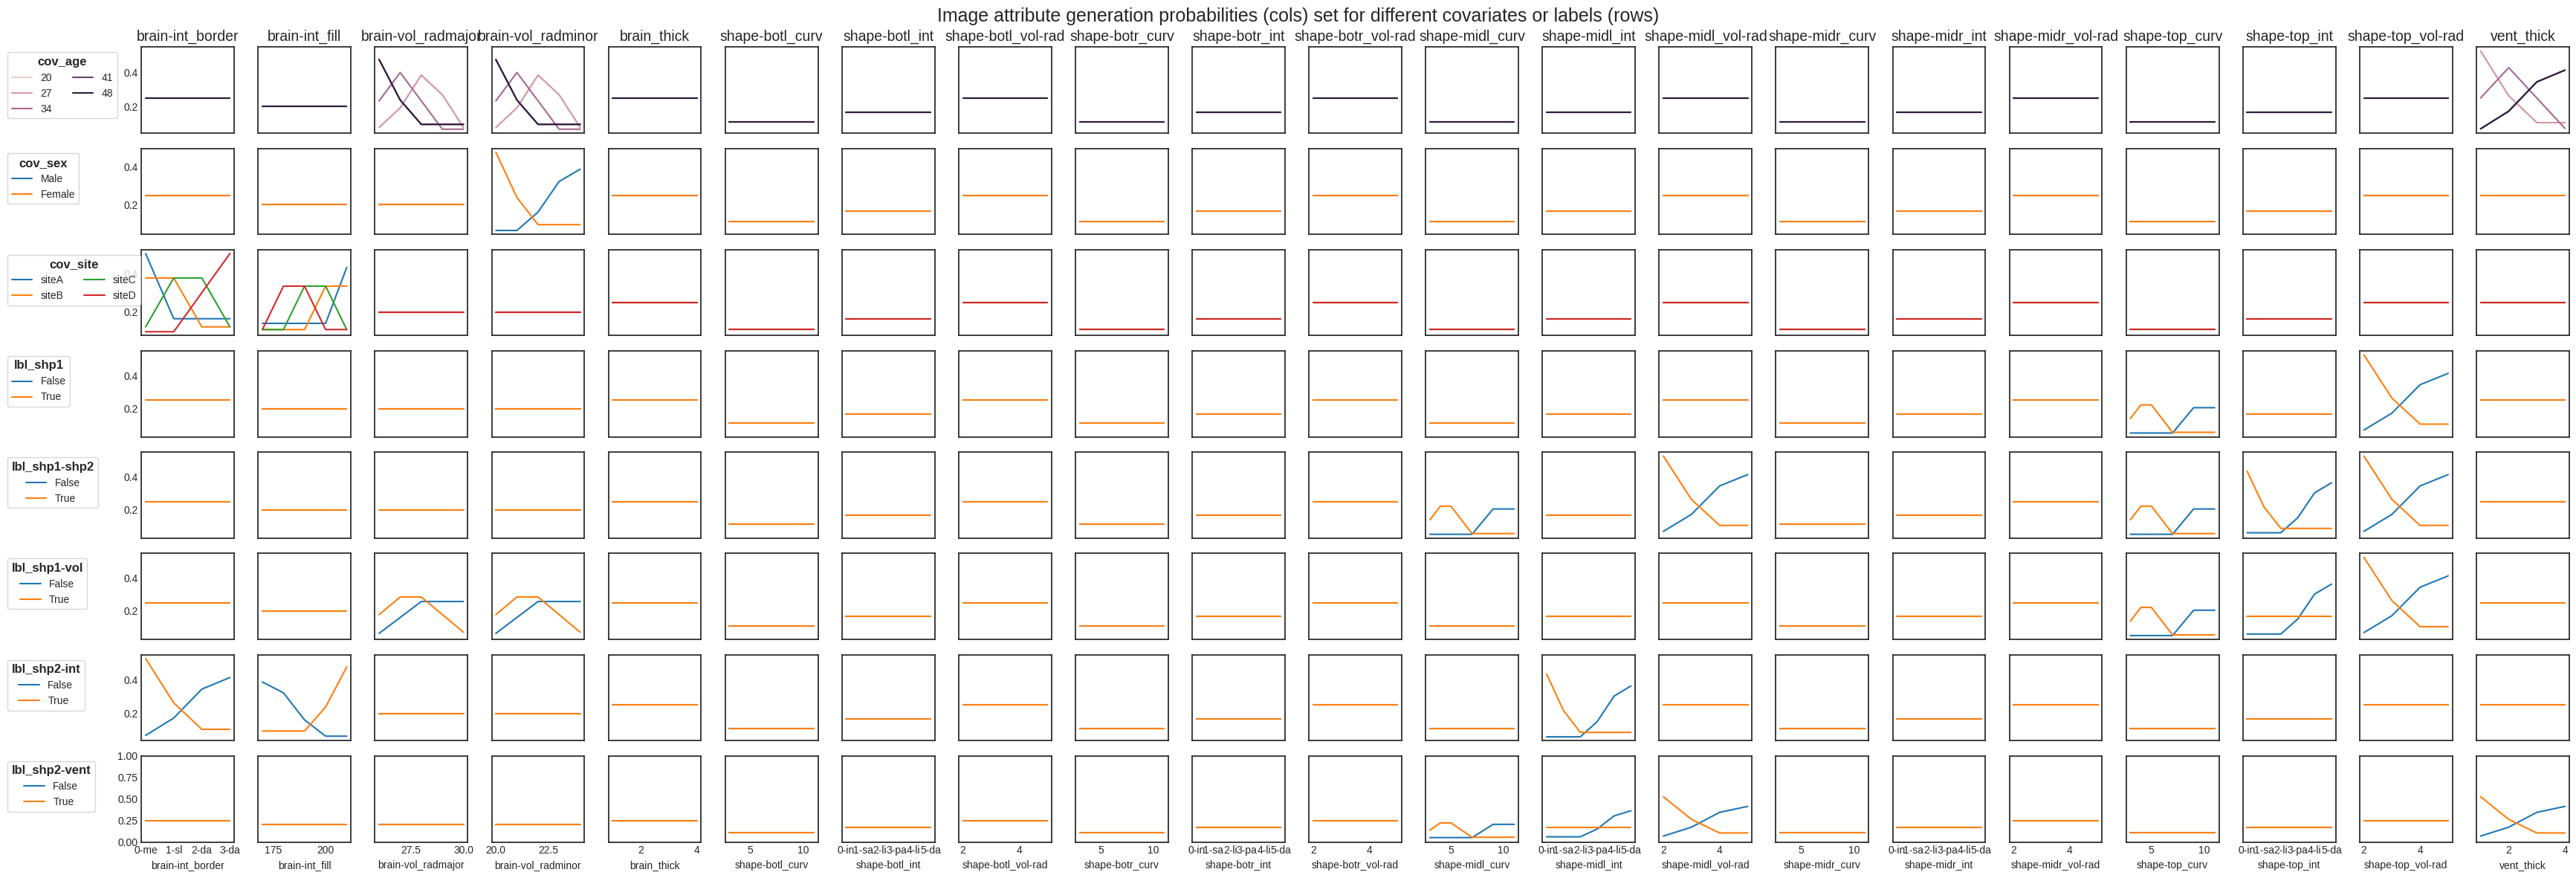

In [9]:
_ = toy.show_current_config() # also returns the nodes and connections of the causal graph

We can also add tweaks to a base config and check how this changes the relationships and probability distributions:

In [48]:
# add a tweaking config "lbl5cov3_tweak_highprobas.py" that will make the probability distributions 
# extremely distinct for all covariates AND it also creates a link between cov_site and shape-midl_int
toy_highprobas = ToyBrainsData(base_config='configs.lbl5cov3_base', 
                               tweak_config='configs.lbl5cov3_tweak_highprobas')

TODO: plot differences in the distributions instead @Jihoon

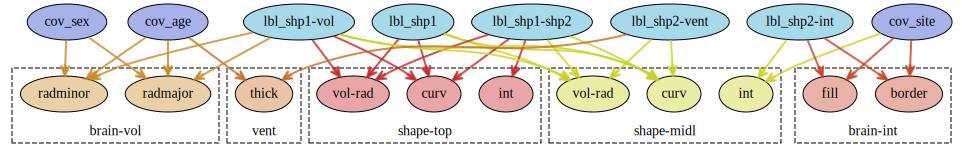

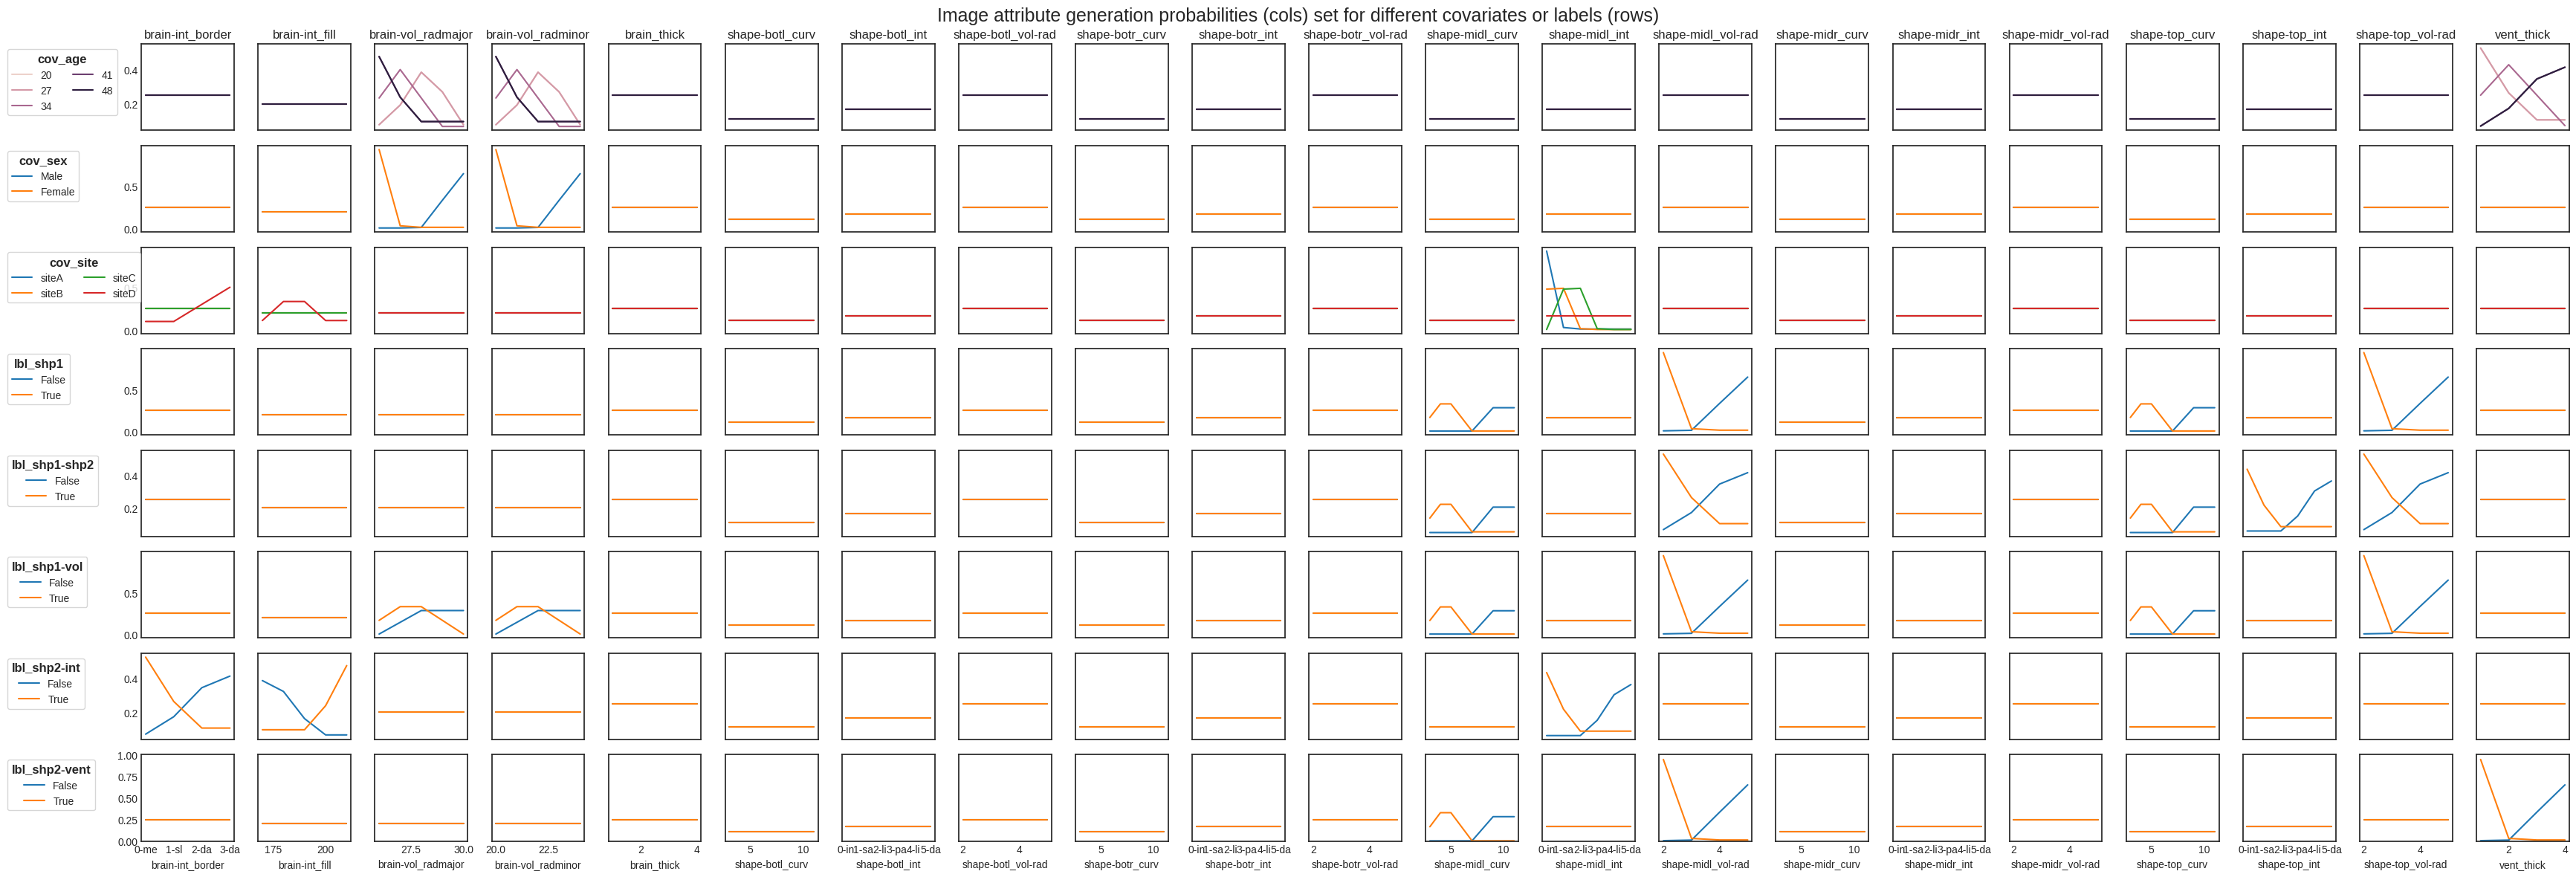

In [20]:
_ = toy_highprobas.show_current_config()

## (Step 2) Generate data table 
Sample the dataset and verify how the distributions will look. 
If some distribution isn't as expected then go back to step 1 and edit the config file accordingly.

In [49]:
df = toy.generate_dataset_table(n_samples=1000)

Sampling n=1000 toybrain image settings


  0%|          | 0/1000 [00:00<?, ?it/s]

### Visualize the dataframe dist.

In [76]:
df.head()

cov_age cov_sex cov_site lbl_shp1 lbl_shp1-shp2 lbl_shp1-vol  \
subjectID                                                                
00000          25    Male    siteC    False         False        False   
00001          43    Male    siteB    False         False         True   
00002          28    Male    siteD    False          True        False   
00003          35    Male    siteB     True          True         True   
00004          33  Female    siteC     True          True         True   

          lbl_shp2-int lbl_shp2-vent gen_brain-vol_radminor  \
subjectID                                                     
00000             True          True                     23   
00001            False          True                     23   
00002             True         False                     22   
00003            False          True                     21   
00004             True          True                     20   

          gen_brain-vol_radmajor  ... _gen_shape-botr_vol-rad  \
subjectID                         ...                           
00000                         28  ...                       4   
00001                         28  ...                       3   
00002                         27  ...                       4   
00003                         26  ...                       3   
00004                         27  ...                       5   

          gen_shape-botl_curv gen_shape-botl_int _gen_shape-botl_vol-rad  \
subjectID                                                                  
00000                       5       4-lightgreen                       4   
00001                       8           1-salmon                       4   
00002                      11           1-salmon                       5   
00003                       5      2-lightsalmon                       2   
00004                       7        0-indianred                       2   

          gen_brain-vol gen_shape-top_vol gen_shape-midr_vol  \
subjectID                                                      
00000       2023.185669         49.250901          12.148745   
00001       2023.185669         70.710678          12.245870   
00002       1866.106036         49.442719          48.000000   
00003       1715.309589         11.755705          70.710678   
00004       1696.460033         10.392305          12.245870   

          gen_shape-midl_vol gen_shape-botr_vol gen_shape-botl_vol  
subjectID                                                           
00000              27.334676          45.254834          47.022820  
00001              26.450336          27.703632          48.983479  
00002              77.254249          41.569219          77.476453  
00003              12.000000          27.703632          11.755705  
00004              11.755705          76.954532          12.148745  

[5 rows x 35 columns]

#### (a) Viz image attributes vs covariates dist.

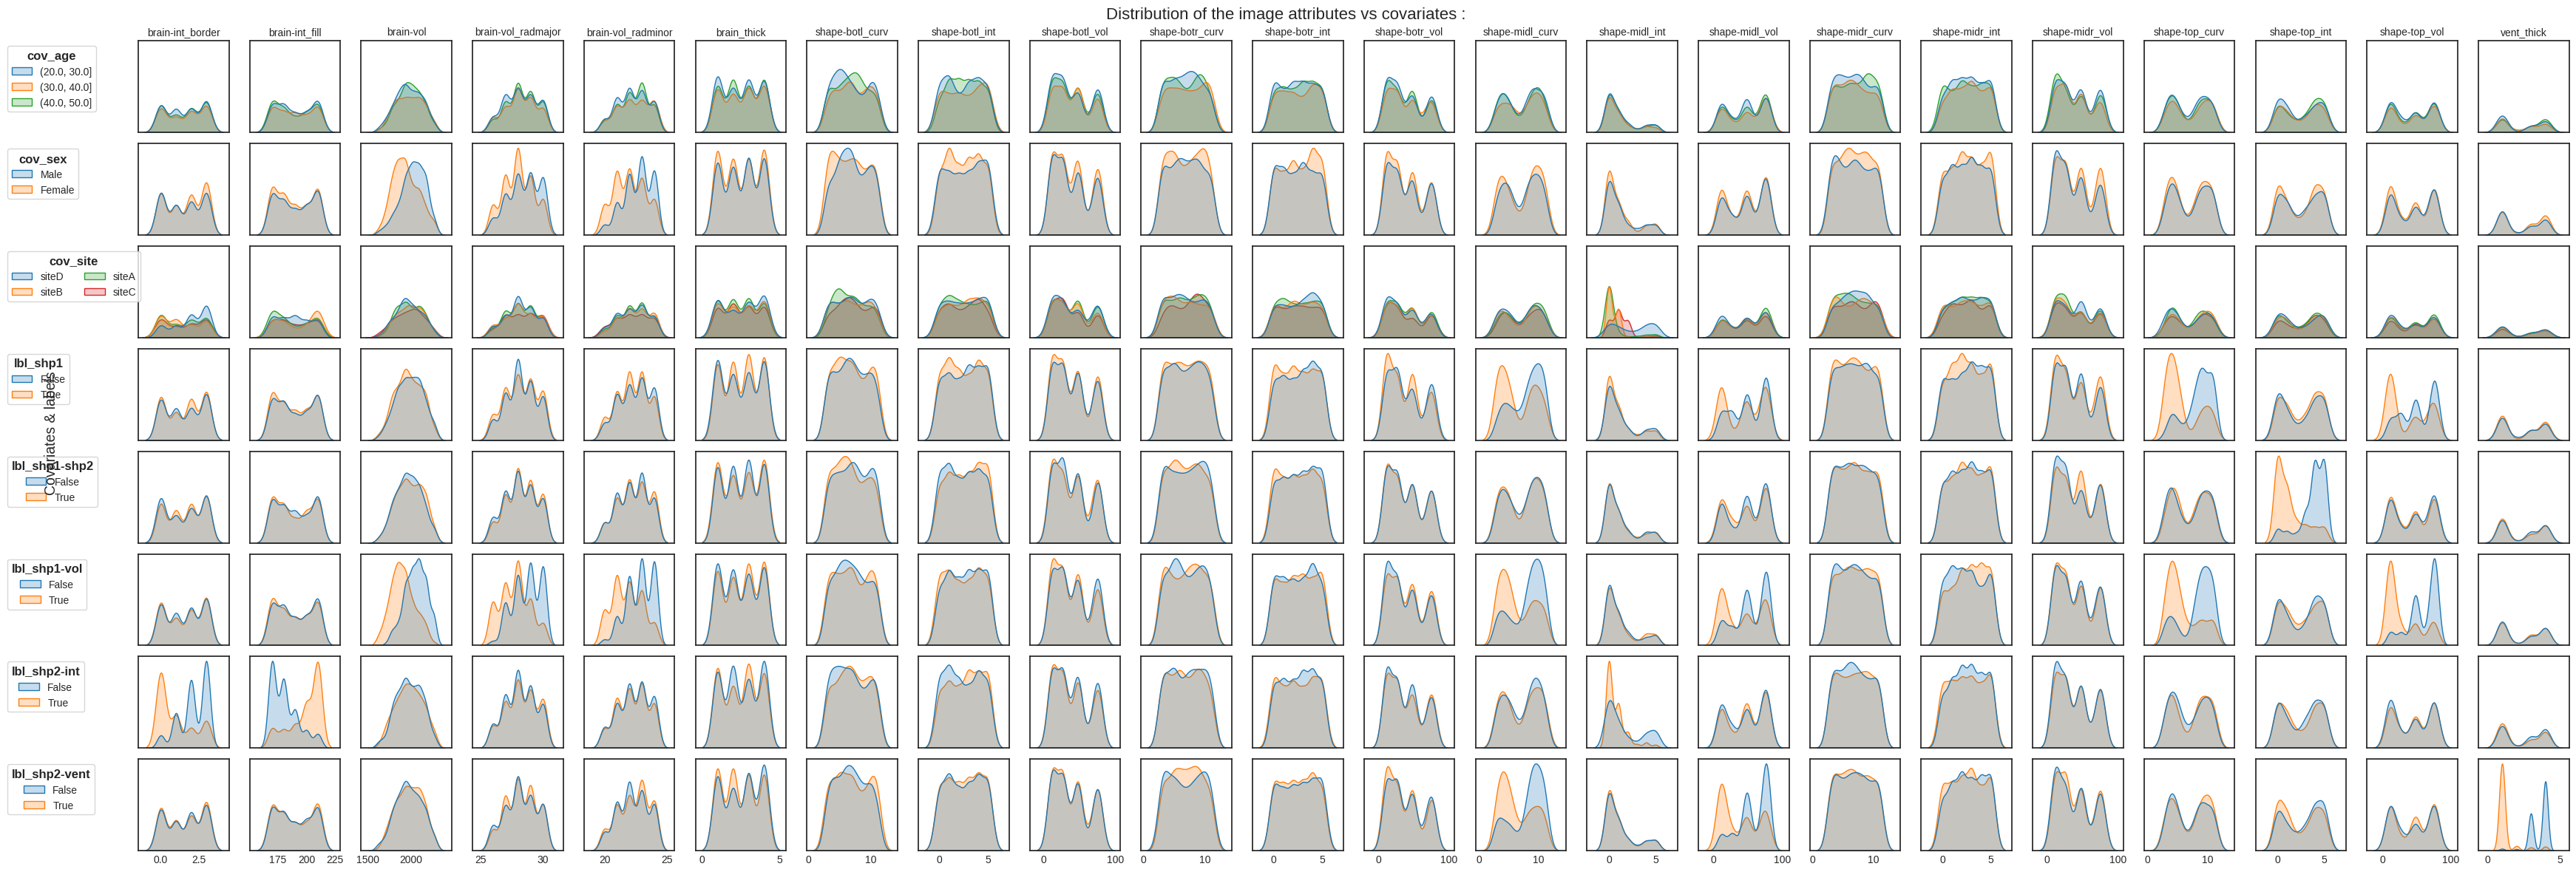

In [25]:
# get all column names starting with 'gen_'
plot_col_dists(df, attr_cols=df.filter(regex='^gen_').columns, cov_cols=df.filter(regex='^(cov_|lbl)').columns, 
               title="Distribution of the image attributes vs covariates :")
plt.show()

#### (b) Viz dist. of all variables in the dataset

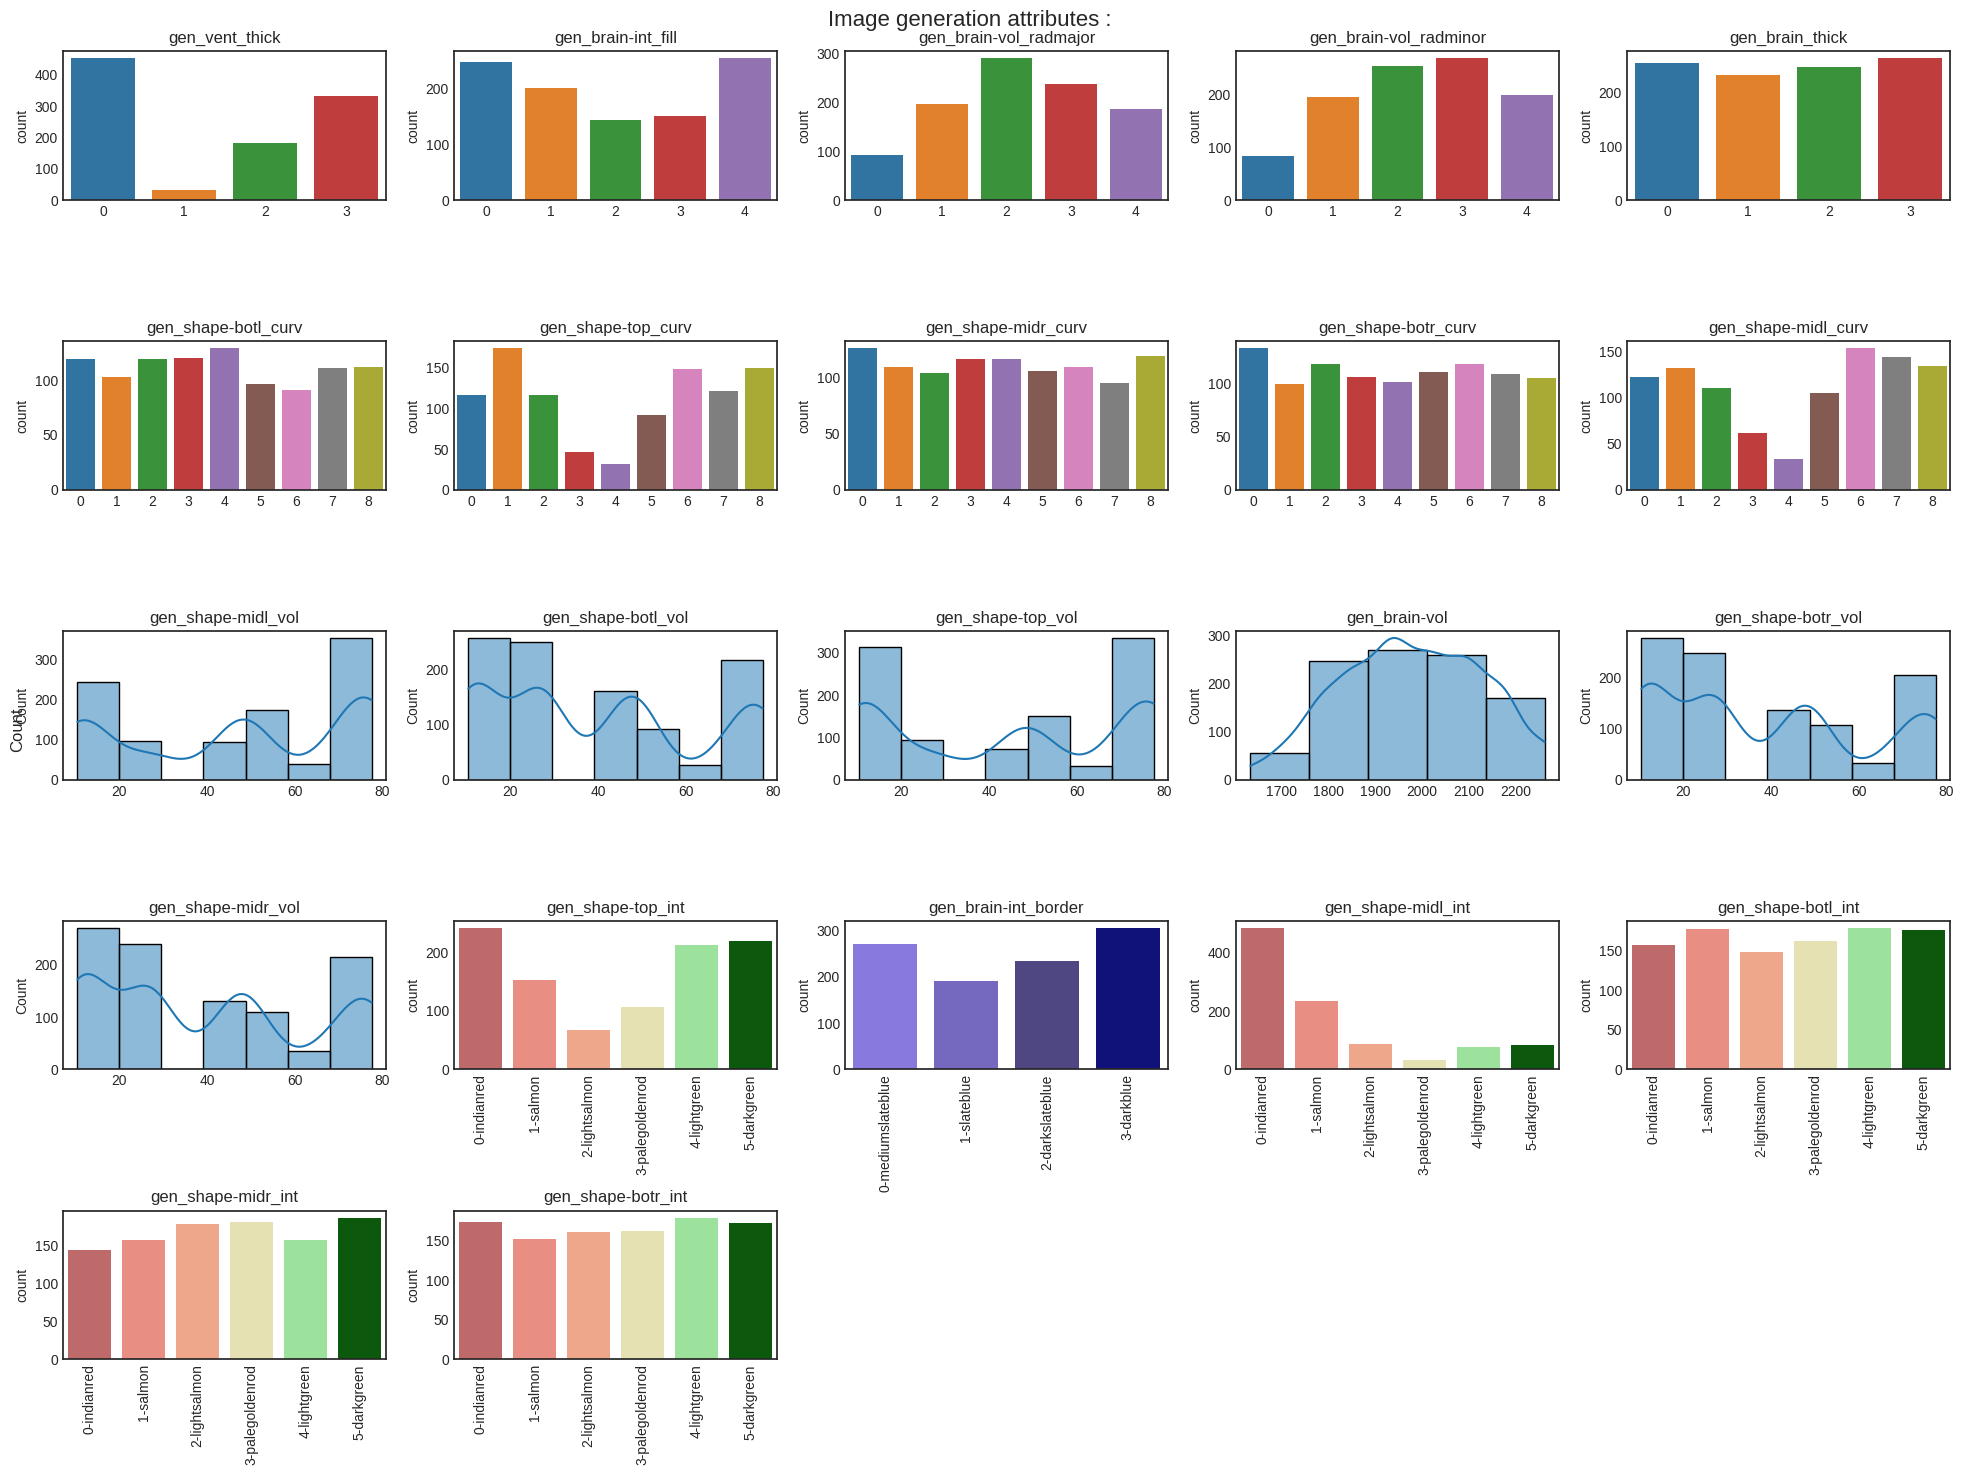

In [26]:
# get all column names starting with 'gen_'
plot_col_counts(df.filter(regex='^gen_'), title="Image generation attributes :")
plt.show()

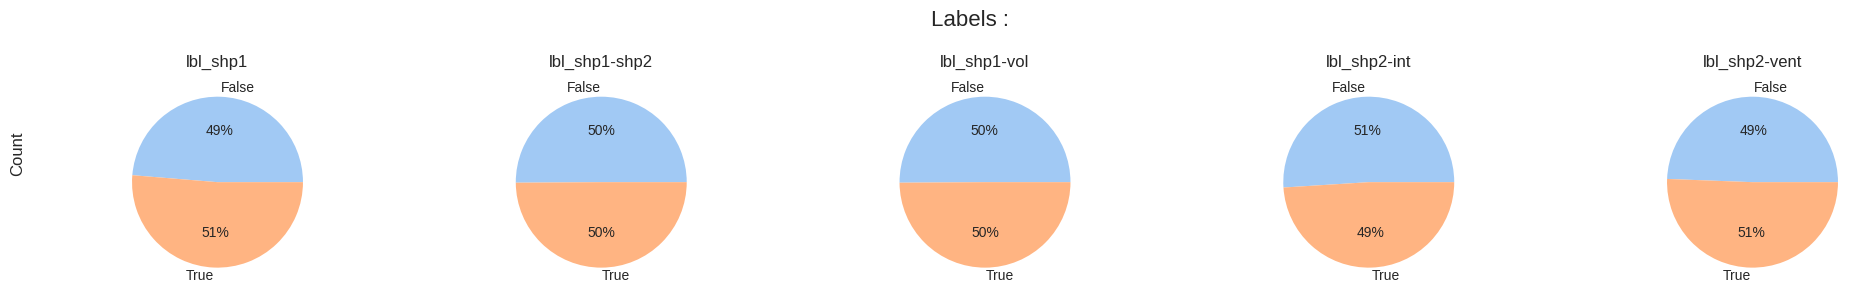

In [27]:
# get all column names starting with 'gen_'
plot_col_counts(df.filter(regex='^lbl'), title="Labels :")
plt.show()

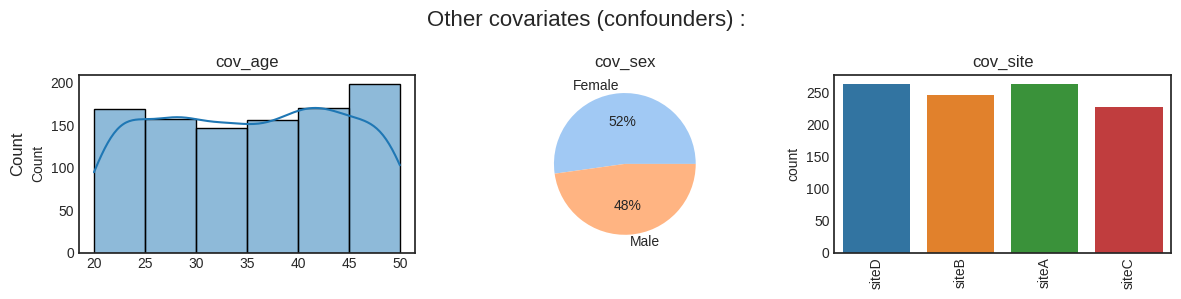

In [28]:
# get all column names starting with 'gen_'
plot_col_counts(df.filter(regex='^cov_'), title="Other covariates (confounders) :")
plt.show()

### Compare with the another config

In [83]:
df_highprobas = toy_highprobas.generate_dataset_table(n_samples=1000, outdir_suffix="n-highprobas")

Sampling n=1000 toybrain image settings


  0%|          | 0/1000 [00:00<?, ?it/s]

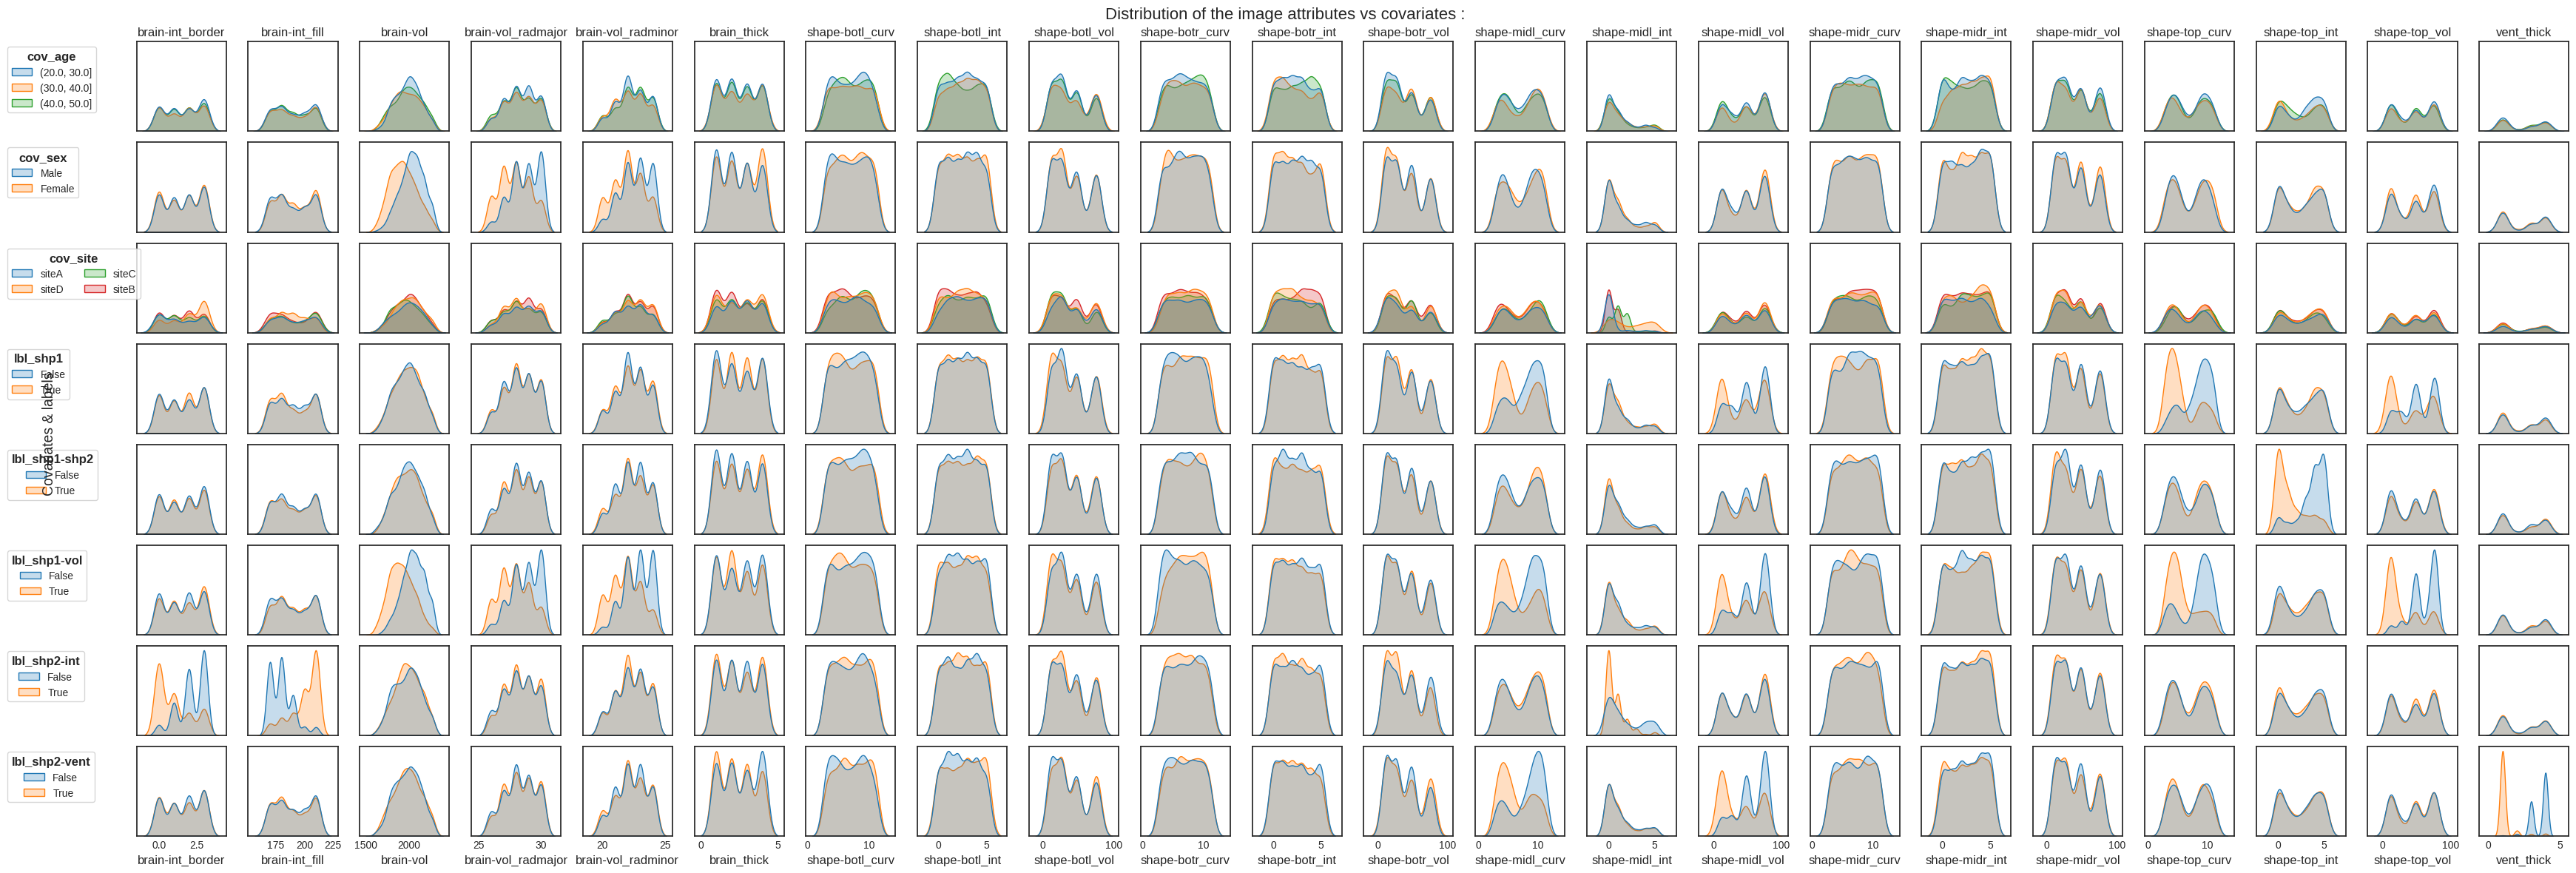

In [34]:
plot_col_dists(df_highprobas, 
               attr_cols=df_highprobas.filter(regex='^gen_').columns, 
               cov_cols=df_highprobas.filter(regex='^(cov_|lbl)').columns, 
               title="Distribution of the image attributes vs covariates :")
plt.show()

## (Step 3) Baseline prediction accuracies
Fit a logistic regression model to predict all labels and covariates from image attributes. <br>
This shows a ground-truth upper bound for the dataset. <br>

running a total of 240 different settings of[input features] x [output labels] x [cross validation] and saving result in dataset/toybrains_n1000


  0%|          | 0/240 [00:00<?, ?it/s]

TOTAL RUNTIME: 0:00:24


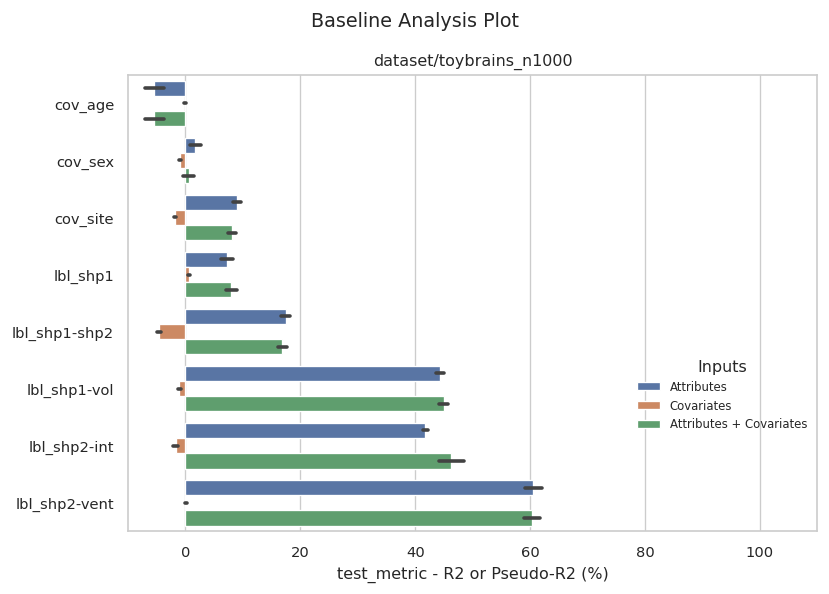

In [106]:
df_results = toy.fit_baseline_models()

Compare with the other dataset with higher probabilities

running a total of 240 different settings of[input features] x [output labels] x [cross validation] and saving result in dataset/toybrains_n1000-highprobas


  0%|          | 0/240 [00:00<?, ?it/s]

TOTAL RUNTIME: 0:00:21


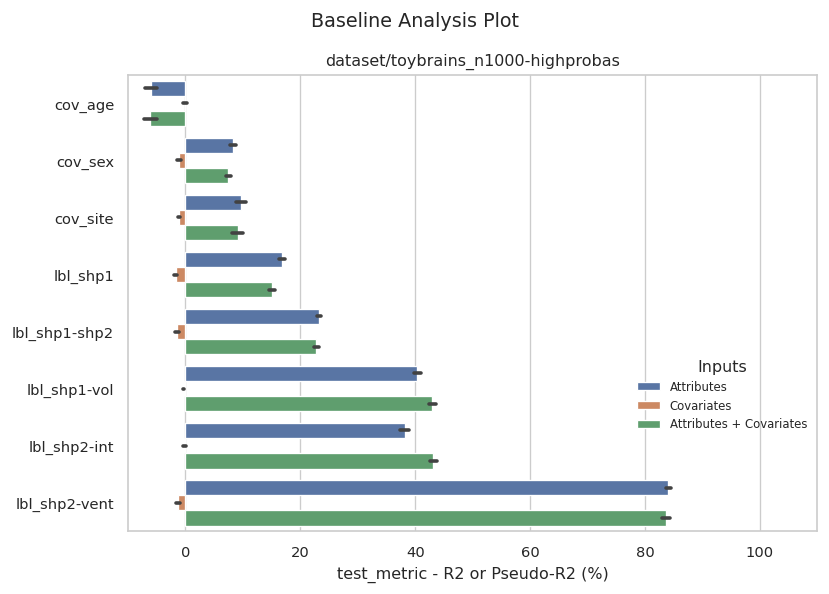

In [107]:
df_results_highprobas = toy_highprobas.fit_baseline_models()

Inspect the results a bit more such as looking for signs of overfitting <br>
(ratio of train_metric to test_metric

In [108]:
toy._show_baseline_results()

## (Step 4) Generate full dataset (with images)

In [85]:
toy.generate_dataset_images(n_jobs=10)

Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]

Visualize some of the generated images

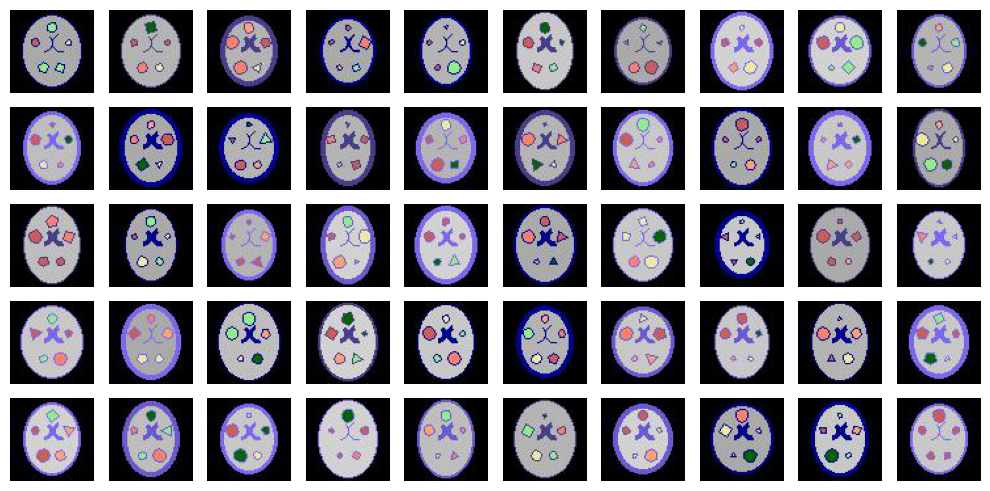

In [86]:
img_files = sorted(glob(f"{toy.OUT_DIR_SUF}/images/*.jpg"))
show_images(img_files=img_files, n_rows=5)

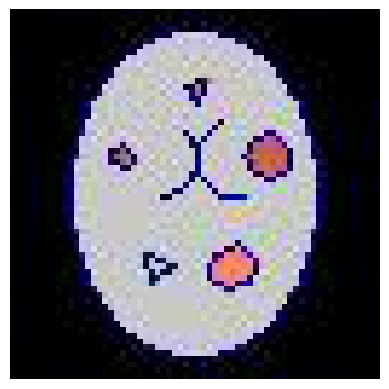

In [87]:
# one random image in detail
img_file = np.random.choice(img_files)
img = mpimg.imread(img_file)
f = plt.figure(frameon=False)
plt.imshow(img)
plt.axis('off')
# plt.savefig("docs/brain.png", bbox_inches='tight')
plt.show()

also generate for the second config

In [88]:
toy_highprobas.generate_dataset_images() 

Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]

## Step 2 & 3 can be run together
with 
```python 
toy.generate_dataset(n_samples=1000)
```
that internally calls
```python 
toy.generate_dataset_table(n_samples=1000)
toy.generate_dataset_images()
```

Alternatively, toybrains dataset can be generated from the command line directly as follows:

In [14]:
# generating 100 samples with debug switch turned on
! python3 create_toybrains.py -c configs.lbl5cov3_base -n 100 -d 

Generative parameter        |        States 
------------------------------------------------------------
brain-vol_radminor         [20 21 22 23 24]
brain-vol_radmajor         [26 27 28 29 30]
brain_thick                [1 2 3 4]
brain-int_fill             [210 200 190 180 170]
brain-int_border           ['0-mediumslateblue' '1-slateblue' '2-darkslateblue' '3-darkblue']
vent_thick                 [1 2 3 4]
shape-top_curv             [ 3  4  5  6  7  8  9 10 11]
shape-top_int              ['0-indianred' '1-salmon' '2-lightsalmon' '3-palegoldenrod' '4-lightgreen'
 '5-darkgreen']
shape-top_vol-rad          [2 3 4 5]
shape-midr_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midr_int             ['0-indianred' '1-salmon' '2-lightsalmon' '3-palegoldenrod' '4-lightgreen'
 '5-darkgreen']
shape-midr_vol-rad         [2 3 4 5]
shape-midl_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midl_int             ['0-indianred' '1-salmon' '2-lightsalmon' '3-palegoldenrod' '4-lightgreen'
 '5-darkg